# PyTorch: CNN for image Classification

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [2]:
if not os.path.isfile('dataset/cifar10.tgz'):
    dataset_url = 'http://files.fast.ai/data/cifar10.tgz'
    download_url(dataset_url, 'dataset/')
else:
    print('Data already downloaded.')

if not os.path.isdir('dataset/cifar10'):
    with tarfile.open('dataset/cifar10.tgz', 'r:gz') as tar:
        tar.extractall(path='dataset/')
else:
    print('Data already extracted.')

Data already downloaded.
Data already extracted.


In [3]:
data_dir = 'dataset/cifar10/'
print(os.listdir(data_dir))

classes = os.listdir(data_dir + 'train')
print(classes)

['labels.txt', 'test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [5]:
dataset = ImageFolder(data_dir + 'train', transform=ToTensor())

In [6]:
img, label = dataset[0]
print(img.shape, label)

torch.Size([3, 32, 32]) 0


In [7]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
import matplotlib.pyplot as plt

In [9]:
def show_image(img, label):
    plt.figure(figsize=(6, 6))
    plt.imshow(img.permute(1, 2, 0))
    plt.title('Label: ' + dataset.classes[label] + ' (' + str(label) + ')') 

**Note: **Here `img.permute()` changes the tensor dimensions from `(3, 32, 32)` to `(32, 32, 3)` as this is how the `plt.imshow()` function expects the image to be.

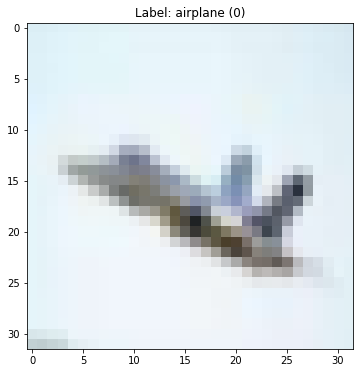

In [10]:
show_image(*dataset[0])

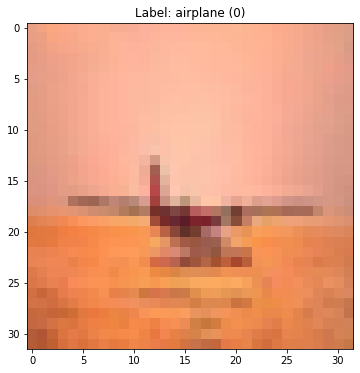

In [11]:
show_image(*dataset[1099])

In [12]:
import numpy as np

In [13]:
def split_indices(n, val_pct=0.1, seed=0):
    n_val = int(val_pct * n)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [14]:
train_idxs, val_idxs = split_indices(len(dataset), val_pct=0.2)
len(train_idxs), len(val_idxs)

(40000, 10000)

In [15]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [16]:
batch_size = 100

train_sampler = SubsetRandomSampler(train_idxs)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_idxs)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

In [17]:
from torchvision.utils import make_grid

def show_batch(dl):
    global fig, ax
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, 10).permute(1, 2, 0))
        return

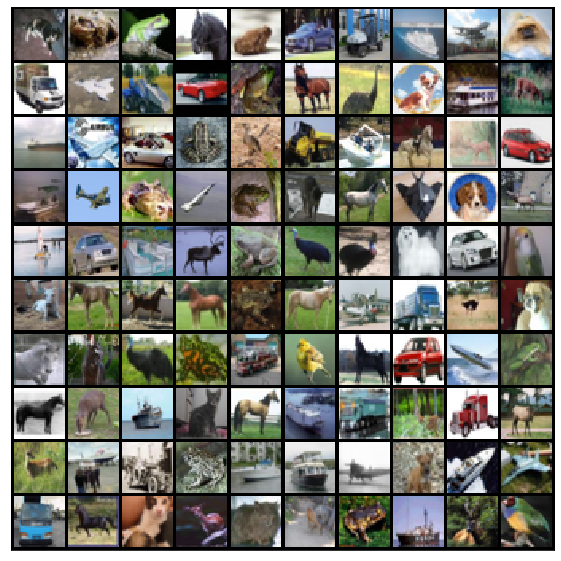

In [18]:
show_batch(train_loader)

In [19]:
import torch.nn as nn
import torch.nn.functional as F

In [20]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [21]:
 for images, labels in train_loader:
     print('input.shape', images.shape)
     out = simple_model(images)
     print('out.shape', out.shape)
     break

input.shape torch.Size([100, 3, 32, 32])
out.shape torch.Size([100, 32, 16, 16])


In [22]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: batch_size x 32 x 16 x 16
    
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: batch_size x 32 x 8 x 8
    
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: batch_size x 32 x 4 x 4
    
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: batch_size x 32 x 2 x 2
    
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2), # output: batch_size x 32 x 1 x 1
    
    nn.Flatten(), # output: batch_size x 32
    
    nn.Linear(32, 256),
    nn.Linear(256, 64),
    nn.Linear(64, 10) # output: batch_size x 10
)

In [23]:
for images, labels in train_loader:
    print('input.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

input.shape: torch.Size([100, 3, 32, 32])
out.shape: torch.Size([100, 10])
out[0]: tensor([ 0.0051, -0.0501,  0.0726,  0.0236, -0.0533, -0.1120, -0.0577,  0.0270,
         0.0909,  0.0267], grad_fn=<SelectBackward>)


In [24]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [25]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [26]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [27]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [28]:
to_device(model, device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten()
  (16): Linear(in_features=32, out_features=256, bias=True)
  (17): Linear(in_features=256, out_features=64, bias=True)
 

In [29]:
# Batch Loss Function
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_func(preds, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

# Model Evaluation Function
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        losses, nums, metrics = zip(*results)
        
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total

    return avg_loss, total, avg_metric

# Model Training Function
def fit(epochs, model, loss_fn, train_dl, valid_dl, opt_fn=None, lr=0.1, metric=None):
    train_losses, val_losses, val_metrics = [], [], []

    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)
        
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)

        if metric is None:
            print('Epoch [{}/{}], Training Loss: {:.5f}, Validation Loss: {:.5f}'.format(epoch + 1, epochs, train_loss, val_loss))
        else:
            print('Epoch [{}/{}], Training Loss: {:.5f}, Validation Loss: {:.5f}, {}: {:.5f}'.format(epoch + 1, epochs, train_loss, val_loss, metric.__name__, val_metric))
    
    return train_losses, val_losses, val_metrics

# Accuracy Function
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [30]:
val_loss, _, val_acc = evaluate(model, F.cross_entropy, val_loader, metric=accuracy)
print('Loss:', val_loss, 'Accuracy:', val_acc)

Loss: 2.3045239543914793 Accuracy: 0.0972


In [31]:
epochs = 25
opt_fn = torch.optim.Adam
lr = 0.005

In [32]:
train_losses, val_losses, val_metrics = fit(epochs, model, F.cross_entropy, train_loader, val_loader, opt_fn=opt_fn, lr=lr, metric=accuracy)

Epoch [1/25], Training Loss: 1.57716, Validation Loss: 1.62910, accuracy: 0.39000
Epoch [2/25], Training Loss: 1.49496, Validation Loss: 1.53807, accuracy: 0.42660
Epoch [3/25], Training Loss: 1.31637, Validation Loss: 1.45196, accuracy: 0.47180
Epoch [4/25], Training Loss: 1.47190, Validation Loss: 1.39950, accuracy: 0.48330
Epoch [5/25], Training Loss: 1.38541, Validation Loss: 1.33883, accuracy: 0.51220
Epoch [6/25], Training Loss: 1.20737, Validation Loss: 1.31123, accuracy: 0.52720
Epoch [7/25], Training Loss: 1.28097, Validation Loss: 1.31956, accuracy: 0.53340
Epoch [8/25], Training Loss: 1.26439, Validation Loss: 1.26939, accuracy: 0.55190
Epoch [9/25], Training Loss: 1.32452, Validation Loss: 1.22542, accuracy: 0.56490
Epoch [10/25], Training Loss: 1.16182, Validation Loss: 1.23417, accuracy: 0.56400
Epoch [11/25], Training Loss: 1.02083, Validation Loss: 1.23374, accuracy: 0.56970
Epoch [12/25], Training Loss: 1.18629, Validation Loss: 1.19179, accuracy: 0.57530
Epoch [13/25]

Text(0.5, 1.0, 'Loss vs Number of epochs')

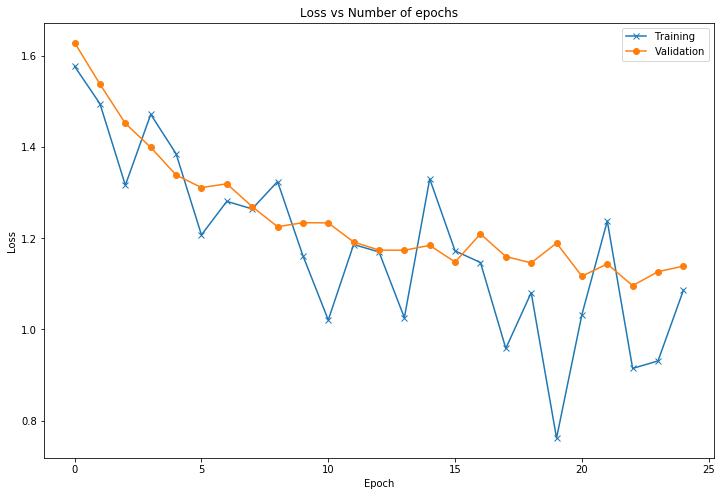

In [33]:
plt.figure(figsize=(12, 8))
plt.plot(train_losses, '-x')
plt.plot(val_losses, '-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs Number of epochs')

Text(0.5, 1.0, 'Accuracy vs Number of epochs')

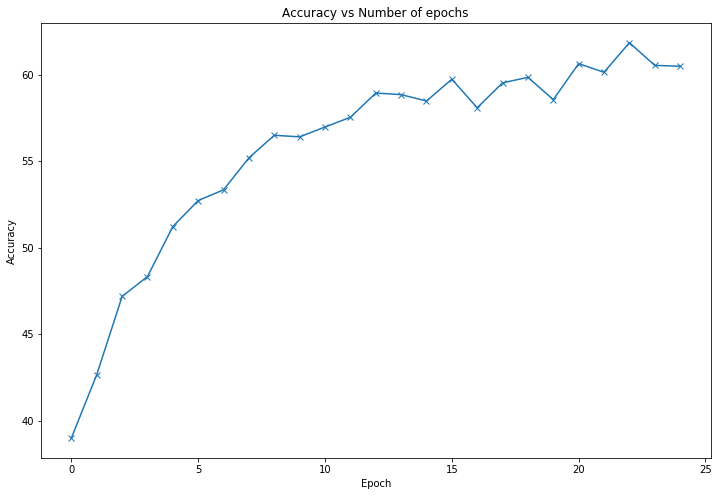

In [34]:
plt.figure(figsize=(12, 8))
plt.plot([x * 100 for x in val_metrics], '-x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of epochs')